In [ ]:
import io
import tarfile
from pathlib import Path

import numpy as np

from ugradiolab.data.schema import CaptureRecord

DATA_SRC = 'data/lab2_cold_cal.tar.gz'  # directory of .npz or .tar.gz archive


def _resolve_source(source):
    src = Path(source).expanduser()
    if src.exists():
        return src

    # Try resolving relative to cwd and all parent directories.
    cwd = Path.cwd().resolve()
    for base in (cwd, *cwd.parents):
        candidate = (base / source).resolve()
        if candidate.exists():
            return candidate

    raise FileNotFoundError(
        f'Could not find {source!r}. cwd={cwd}. '
        'Tried cwd and all parent directories.'
    )


def _prefix_from_name(name):
    # filename convention: {prefix}_{cal|obs}_{YYYYMMDD}_{HHMMSS}.npz
    return Path(name).name.rsplit('_', 3)[0]


def _parse_dbm(prefix, stem):
    if not prefix.startswith(stem):
        return None
    try:
        return int(prefix.replace(stem, ''))
    except ValueError:
        return None


def load_dataset(source):
    src = _resolve_source(source)
    data = {}

    if src.is_dir():
        files = sorted(src.glob('*.npz'))
        for f in files:
            data[_prefix_from_name(f.name)] = CaptureRecord.load(f)
    elif src.is_file() and src.suffixes[-2:] == ['.tar', '.gz']:
        with tarfile.open(src, 'r:gz') as tar:
            members = sorted(
                [m for m in tar.getmembers() if m.isfile() and m.name.endswith('.npz')],
                key=lambda m: m.name,
            )
            for m in members:
                extracted = tar.extractfile(m)
                if extracted is None:
                    continue
                data[_prefix_from_name(m.name)] = CaptureRecord.load(
                    io.BytesIO(extracted.read())
                )
    else:
        raise FileNotFoundError(
            f'Expected a directory of .npz files or a .tar.gz archive, got: {src}'
        )

    if not data:
        raise RuntimeError(f'No .npz files found in: {src}')

    return data, src


# Load every .npz into a dict keyed by prefix (e.g. COLD-TONE--35, COLD-BASE-PRE)
data, resolved_src = load_dataset(DATA_SRC)

# Discover available paired calibration levels from what is actually present.
tone_dbm = sorted(
    d for d in (_parse_dbm(prefix, 'COLD-TONE-') for prefix in data) if d is not None
)
base_dbm = sorted(
    d for d in (_parse_dbm(prefix, 'COLD-BASE-') for prefix in data) if d is not None
)
paired_dbm = sorted(set(tone_dbm).intersection(base_dbm))

if not paired_dbm:
    raise RuntimeError('No paired COLD-TONE-<dBm> and COLD-BASE-<dBm> captures found.')

print(f'Loaded {len(data)} files from {resolved_src}')
print(f'Paired dBm levels: {paired_dbm}')
for key in sorted(data):
    kind = 'cal' if data[key].siggen_freq is not None else 'obs'
    print(f'  {key:20s} ({kind})')


In [ ]:
import pandas as pd


def to_complex(raw):
    """Convert (nblocks, nsamples, 2) int8 I/Q to (nblocks, nsamples) complex128."""
    return raw[..., 0].astype(np.float64) + 1j * raw[..., 1].astype(np.float64)


rows = []
for prefix, rec in data.items():
    is_cal = rec.siggen_freq is not None
    rows.append({
        'prefix': prefix,
        'type': 'cal' if is_cal else 'obs',
        'samples': to_complex(rec.data),
        'sample_rate': rec.sample_rate,
        'center_freq': rec.center_freq,
        'gain': rec.gain,
        'direct': rec.direct,
        'unix_time': rec.unix_time,
        'jd': rec.jd,
        'lst': rec.lst,
        'alt': rec.alt,
        'az': rec.az,
        'siggen_freq': rec.siggen_freq if is_cal else np.nan,
        'siggen_amp': rec.siggen_amp if is_cal else np.nan,
        'siggen_rf_on': rec.siggen_rf_on if is_cal else False,
    })

if not rows:
    raise RuntimeError('No captures loaded into rows; check DATA_SRC and load_dataset().')

if 'unix_time' not in rows[0]:
    raise KeyError('unix_time is missing in loaded capture metadata.')

df = pd.DataFrame(rows).sort_values('unix_time').reset_index(drop=True)
df


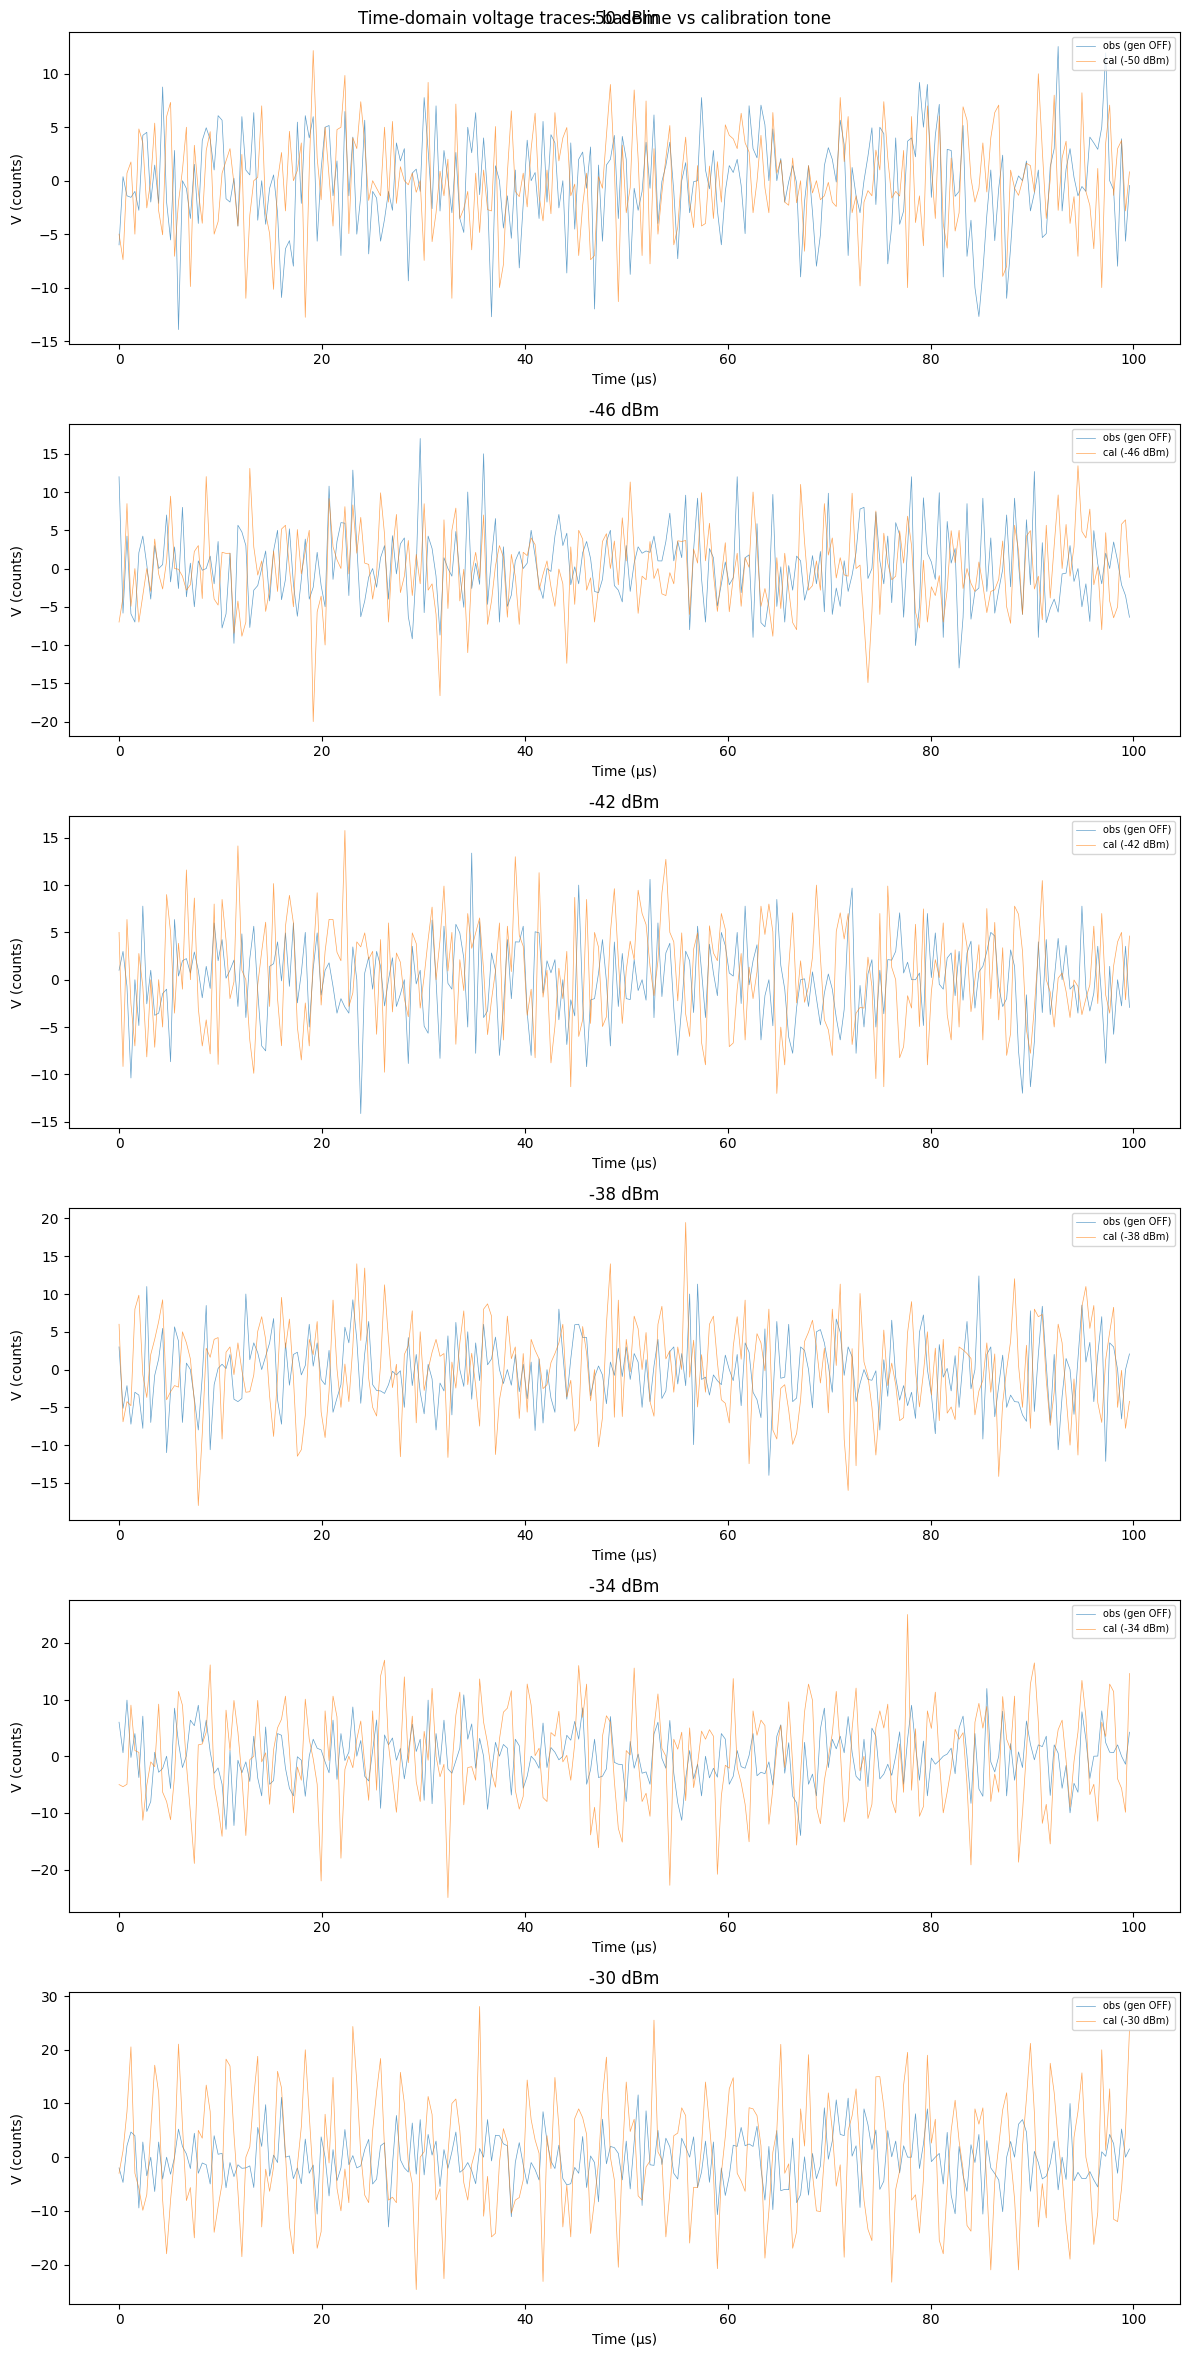

In [3]:
import matplotlib.pyplot as plt

sample_rate = 2.56e6
center_freq = 1.42e9
nshow = 256  # samples to plot (first block only)

t_us = np.arange(nshow) / sample_rate * 1e6  # time axis in microseconds

fig, axes = plt.subplots(len(paired_dbm), 1, figsize=(12, 4 * len(paired_dbm)))
axes = np.atleast_1d(axes)

for i, dbm in enumerate(paired_dbm):
    ax = axes[i]
    tone_key = f'COLD-TONE-{dbm}'
    base_key = f'COLD-BASE-{dbm}'

    cal_iq = df.loc[df['prefix'] == tone_key, 'samples'].values[0]
    obs_iq = df.loc[df['prefix'] == base_key, 'samples'].values[0]

    # Reconstruct RF: V(t) = I(t)cos(2π f_c t) - Q(t)sin(2π f_c t)
    t_s = np.arange(nshow) / sample_rate
    carrier_cos = np.cos(2 * np.pi * center_freq * t_s)
    carrier_sin = np.sin(2 * np.pi * center_freq * t_s)

    cal_rf = cal_iq[0, :nshow].real * carrier_cos - cal_iq[0, :nshow].imag * carrier_sin
    obs_rf = obs_iq[0, :nshow].real * carrier_cos - obs_iq[0, :nshow].imag * carrier_sin

    ax.plot(t_us, obs_rf, alpha=0.7, lw=0.5, label='obs (gen OFF)')
    ax.plot(t_us, cal_rf, alpha=0.7, lw=0.5, label=f'cal ({dbm} dBm)')
    ax.set_ylabel('V (counts)')
    ax.set_xlabel('Time (μs)')
    ax.set_title(f'{dbm} dBm')
    ax.legend(loc='upper right', fontsize=7)

fig.suptitle('Time-domain voltage traces: baseline vs calibration tone')
plt.tight_layout()
plt.show()



In [4]:
def power_spectrum(iq, sample_rate, center_freq):
    """Compute mean power spectrum from complex I/Q data.

    Parameters
    ----------
    iq : (nblocks, nsamples) complex array
    sample_rate, center_freq : float

    Returns
    -------
    freqs_mhz : frequency axis in MHz (DC bin omitted)
    psd : mean |FFT|^2 averaged over blocks (DC bin omitted)
    """
    nblocks, nsamples = iq.shape
    # Complex FFT + shift so DC is centered
    fft_data = np.fft.fftshift(np.fft.fft(iq, axis=1), axes=1)
    psd = np.mean(np.abs(fft_data)**2, axis=0)
    freqs = np.fft.fftshift(np.fft.fftfreq(nsamples, d=1.0/sample_rate))
    freqs_mhz = (freqs + center_freq) / 1e6
    # Omit DC bin (LO leakage)
    dc = nsamples // 2
    mask = np.ones(nsamples, dtype=bool)
    mask[dc] = False
    return freqs_mhz[mask], psd[mask]

# Compute power spectra for all 44 captures
sample_rate = df['sample_rate'].iloc[0]
center_freq = df['center_freq'].iloc[0]

df['freqs_mhz'] = None
df['psd'] = None
for idx, row in df.iterrows():
    freqs_mhz, psd = power_spectrum(row['samples'], sample_rate, center_freq)
    df.at[idx, 'freqs_mhz'] = freqs_mhz
    df.at[idx, 'psd'] = psd

print(f'Computed power spectra for {len(df)} captures')
print(f'Frequency range: {freqs_mhz[0]:.3f} – {freqs_mhz[-1]:.3f} MHz')
print(f'Frequency bins: {len(freqs_mhz)}')

Computed power spectra for 14 captures
Frequency range: 1418.720 – 1421.279 MHz
Frequency bins: 2047


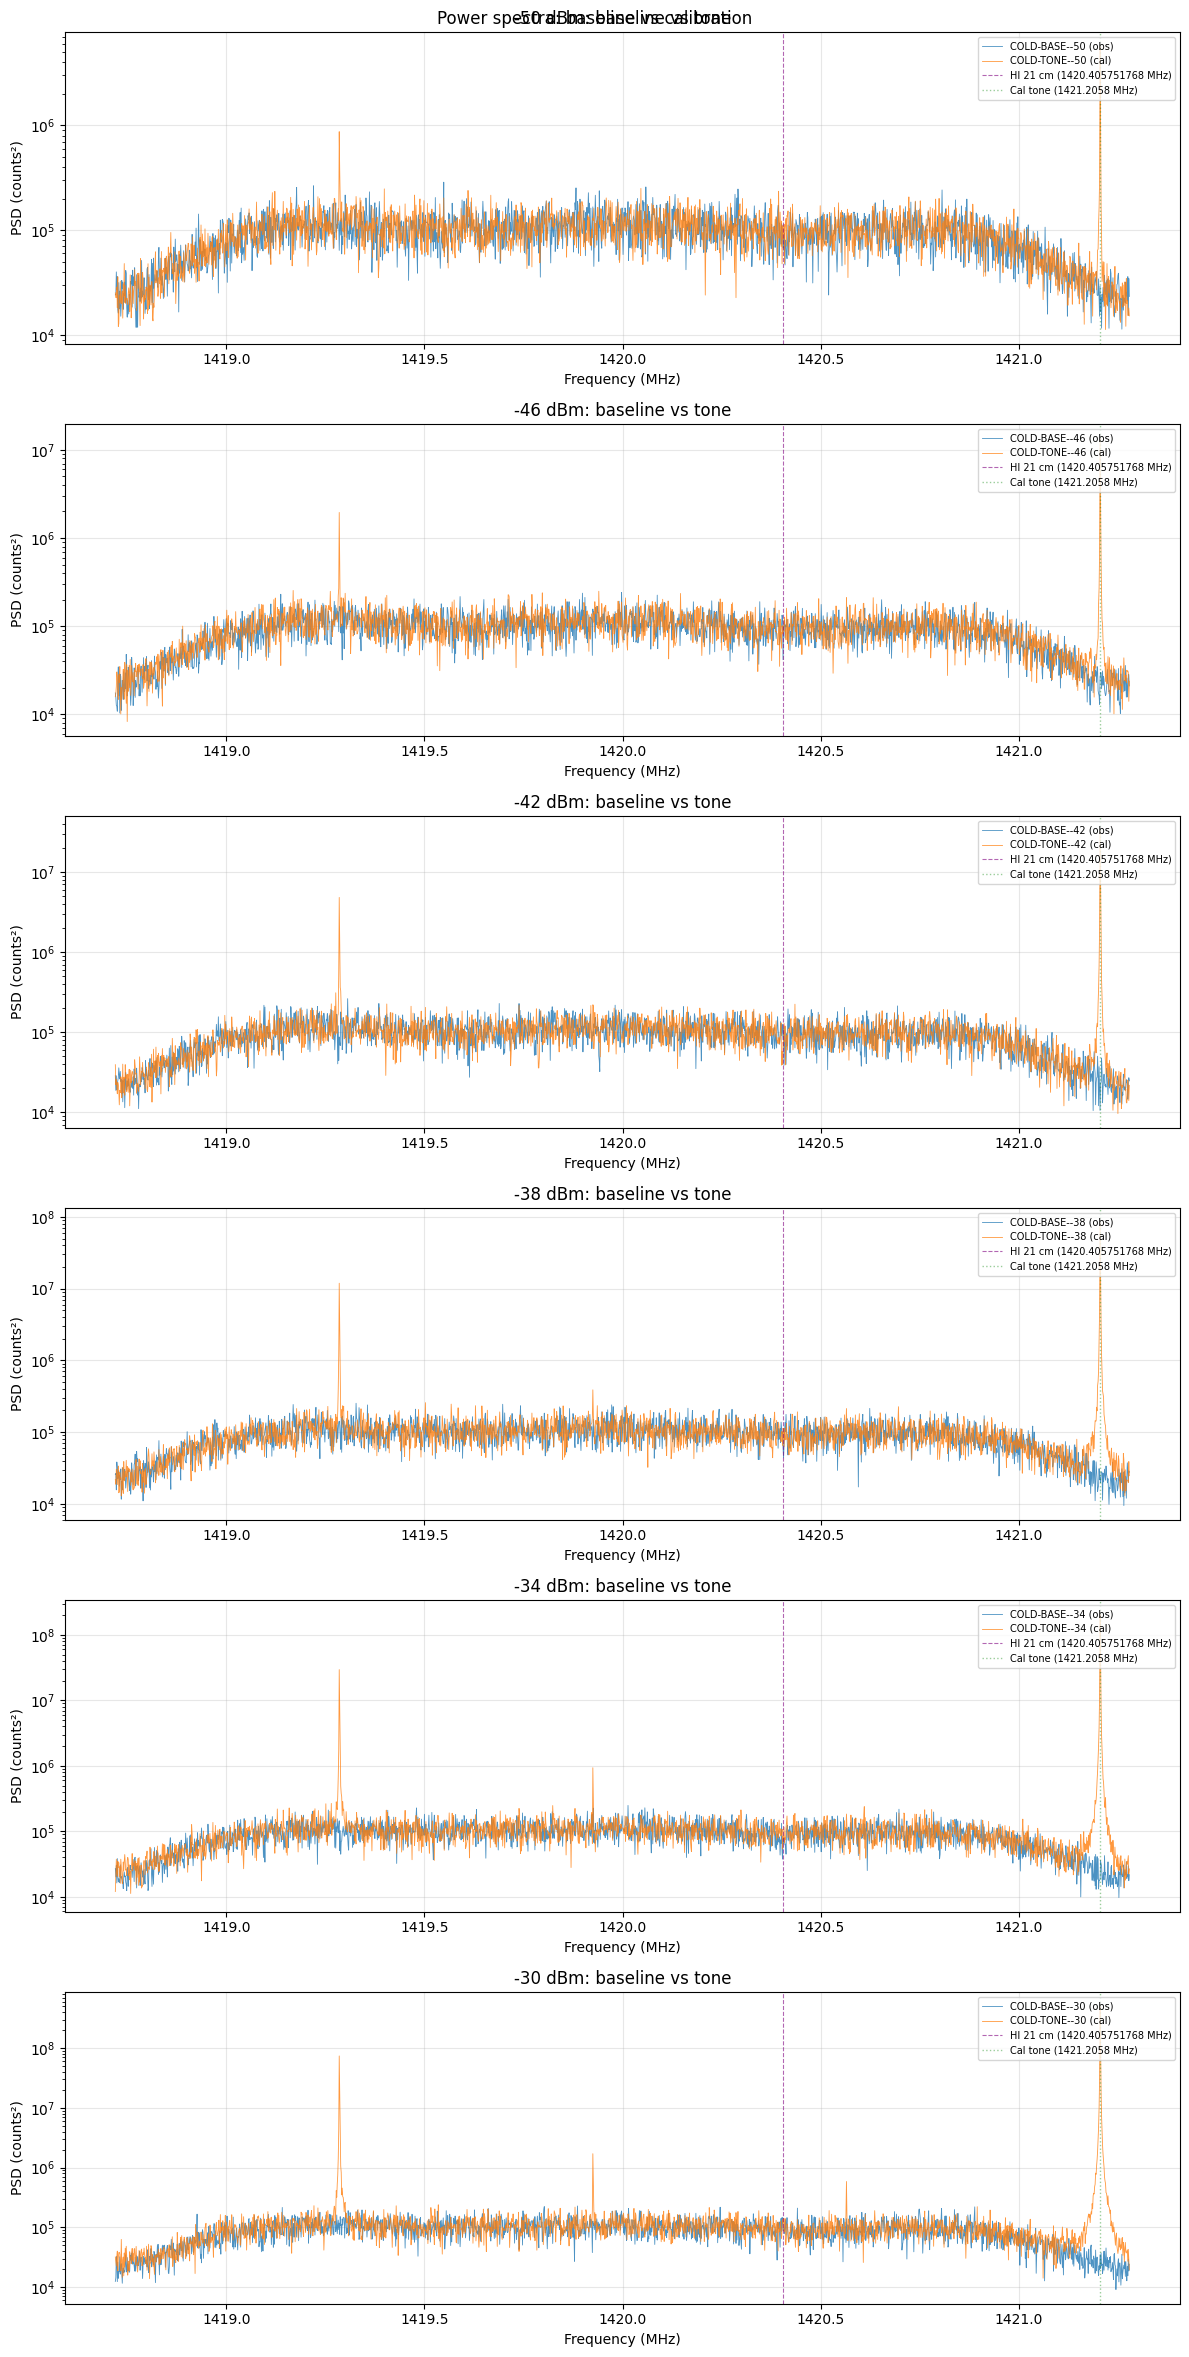

In [9]:
# Power spectrum plots for each available paired dBm level
HI_FREQ = 1420.405751768  # 21-cm hydrogen line (MHz)
CAL_TONE_MHZ = 1421.2058  # calibration tone frequency

plot_pairs = []
for dbm in paired_dbm:
    plot_pairs.append((f'COLD-BASE-{dbm}', f'COLD-TONE-{dbm}', f'{dbm} dBm: baseline vs tone'))

fig, axes = plt.subplots(len(plot_pairs), 1, figsize=(12, 4 * len(plot_pairs)))
axes = np.atleast_1d(axes)

for i, (obs_key, cal_key, title) in enumerate(plot_pairs):
    ax = axes[i]
    obs_row = df.loc[df['prefix'] == obs_key].iloc[0]
    cal_row = df.loc[df['prefix'] == cal_key].iloc[0]

    ax.semilogy(obs_row['freqs_mhz'], obs_row['psd'], lw=0.6, alpha=0.8, label=f'{obs_key} (obs)')
    ax.semilogy(cal_row['freqs_mhz'], cal_row['psd'], lw=0.6, alpha=0.8, label=f'{cal_key} (cal)')
    ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--', label=f'HI 21 cm ({HI_FREQ} MHz)')
    ax.axvline(CAL_TONE_MHZ, color='green', alpha=0.4, lw=1, ls=':',
               label=f'Cal tone ({CAL_TONE_MHZ} MHz)')
    ax.set_ylabel('PSD (counts²)')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('Power spectra: baseline vs calibration')
plt.tight_layout()
plt.show()



In [6]:
# Summary statistics DataFrame
tone_freq_mhz = 1421.2058

stats_rows = []
for dbm in paired_dbm:
    tone_row = df.loc[df['prefix'] == f'COLD-TONE-{dbm}'].iloc[0]
    base_row = df.loc[df['prefix'] == f'COLD-BASE-{dbm}'].iloc[0]

    freqs = tone_row['freqs_mhz']
    tone_psd = tone_row['psd']
    base_psd = base_row['psd']

    # Find the bin closest to the tone frequency
    tone_bin = np.argmin(np.abs(freqs - tone_freq_mhz))

    stats_rows.append({
        'siggen_amp_dBm': dbm,
        'tone_peak_psd': tone_psd[tone_bin],
        'base_psd_at_tone': base_psd[tone_bin],
        'tone_total_psd': np.sum(tone_psd),
        'base_total_psd': np.sum(base_psd),
        'tone_mean_psd': np.mean(tone_psd),
        'base_mean_psd': np.mean(base_psd),
        'tone_peak_freq_mhz': freqs[np.argmax(tone_psd)],
        'peak_snr_dB': 10 * np.log10(tone_psd[tone_bin] / base_psd[tone_bin]),
    })

psd_stats = pd.DataFrame(stats_rows)
psd_stats



,siggen_amp_dBm,tone_peak_psd,base_psd_at_tone,tone_total_psd,base_total_psd,tone_mean_psd,base_mean_psd,tone_peak_freq_mhz,peak_snr_dB
0,-50,1.175910e+06,16663.242525,1.995853e+08,188405540.2,97501.344113,92039.834001,1421.205,18.486146
1,-46,2.817068e+06,29779.230592,2.129929e+08,183859462.9,104051.262189,89818.985296,1421.205,19.758838
2,-42,7.406017e+06,23435.322237,2.423514e+08,187488359.4,118393.440156,91591.773034,1421.205,24.997138
3,-38,1.804170e+07,19823.520663,3.208492e+08,184058878.6,156741.164436,89916.403810,1421.205,29.590966
4,-34,4.675030e+07,35640.433710,5.222520e+08,182776269.2,255130.456571,89289.823742,1421.205,31.178414
5,-30,1.192463e+08,20299.862755,1.014963e+09,179833213.1,495829.558329,87852.082609,1421.205,37.689518


In [7]:
from scipy.signal import find_peaks

def find_significant_peaks(freqs_mhz, psd, prominence_factor=5.0, min_distance=5):
    """Find peaks that stand significantly above the local noise floor.

    Parameters
    ----------
    freqs_mhz : array, frequency axis
    psd : array, power spectral density
    prominence_factor : float, peak must be this many times the median PSD
    min_distance : int, minimum bin separation between peaks

    Returns
    -------
    list of dicts with freq_mhz, psd_value, prominence, snr_over_median
    """
    median_psd = np.median(psd)
    # Find peaks with prominence above median * factor
    peak_idx, properties = find_peaks(
        psd,
        prominence=median_psd * prominence_factor,
        distance=min_distance,
    )
    results = []
    for i, pidx in enumerate(peak_idx):
        results.append({
            'freq_mhz': freqs_mhz[pidx],
            'psd': psd[pidx],
            'prominence': properties['prominences'][i],
            'snr_over_median_dB': 10 * np.log10(psd[pidx] / median_psd),
        })
    return results

# Run peak detection on all 44 captures
peak_rows = []
for _, row in df.iterrows():
    peaks = find_significant_peaks(row['freqs_mhz'], row['psd'], prominence_factor=3.0)
    for p in peaks:
        peak_rows.append({
            'prefix': row['prefix'],
            'type': row['type'],
            'siggen_amp': row['siggen_amp'],
            **p,
        })

peaks_df = pd.DataFrame(peak_rows)
print(f'Found {len(peaks_df)} significant peaks across all captures\n')

# Show unique peak frequencies (rounded to nearest bin)
if len(peaks_df) > 0:
    peaks_df['freq_rounded'] = peaks_df['freq_mhz'].round(3)
    print('Peak frequency summary (all captures):')
    freq_counts = peaks_df.groupby('freq_rounded').agg(
        count=('prefix', 'count'),
        in_cal=('type', lambda x: (x == 'cal').sum()),
        in_obs=('type', lambda x: (x == 'obs').sum()),
        max_snr_dB=('snr_over_median_dB', 'max'),
        mean_snr_dB=('snr_over_median_dB', 'mean'),
    ).sort_values('count', ascending=False)
    print(freq_counts.to_string())
    print()

peaks_df

Found 18 significant peaks across all captures

Peak frequency summary (all captures):
              count  in_cal  in_obs  max_snr_dB  mean_snr_dB
freq_rounded                                                
1419.285          6       6       0   28.879383    19.211720
1421.205          6       6       0   37.153190    27.552938
1419.925          3       3       0   12.520805     9.636887
1419.205          1       0       1    5.223903     5.223903
1419.549          1       0       1    5.008711     5.008711
1420.565          1       1       0    7.876312     7.876312



,prefix,type,siggen_amp,freq_mhz,psd,prominence,snr_over_median_dB,freq_rounded
0,COLD-BASE-PRE,obs,NaN,1419.20500,3.015439e+05,2.907691e+05,5.223903,1419.205
1,COLD-TONE--50,cal,-50.0,1419.28500,8.721027e+05,8.594823e+05,9.725791,1419.285
2,COLD-TONE--50,cal,-50.0,1421.20500,5.677901e+06,5.665877e+06,17.861992,1421.205
3,COLD-BASE--50,obs,NaN,1419.54875,2.871801e+05,2.754047e+05,5.008711,1419.549
4,COLD-TONE--46,cal,-46.0,1419.28500,1.951685e+06,1.936075e+06,13.223758,1419.285
5,COLD-TONE--46,cal,-46.0,1421.20500,1.349258e+07,1.348249e+07,21.620610,1421.205
6,COLD-TONE--42,cal,-42.0,1419.28500,4.817204e+06,4.805113e+06,17.190429,1419.285
7,COLD-TONE--42,cal,-42.0,1421.20500,3.296111e+07,3.294902e+07,25.542497,1421.205
8,COLD-TONE--38,cal,-38.0,1419.28500,1.190859e+07,1.188917e+07,21.209397,1419.285
9,COLD-TONE--38,cal,-38.0,1419.92500,3.879534e+05,3.480509e+05,6.338589,1419.925


IndexError: single positional indexer is out-of-bounds

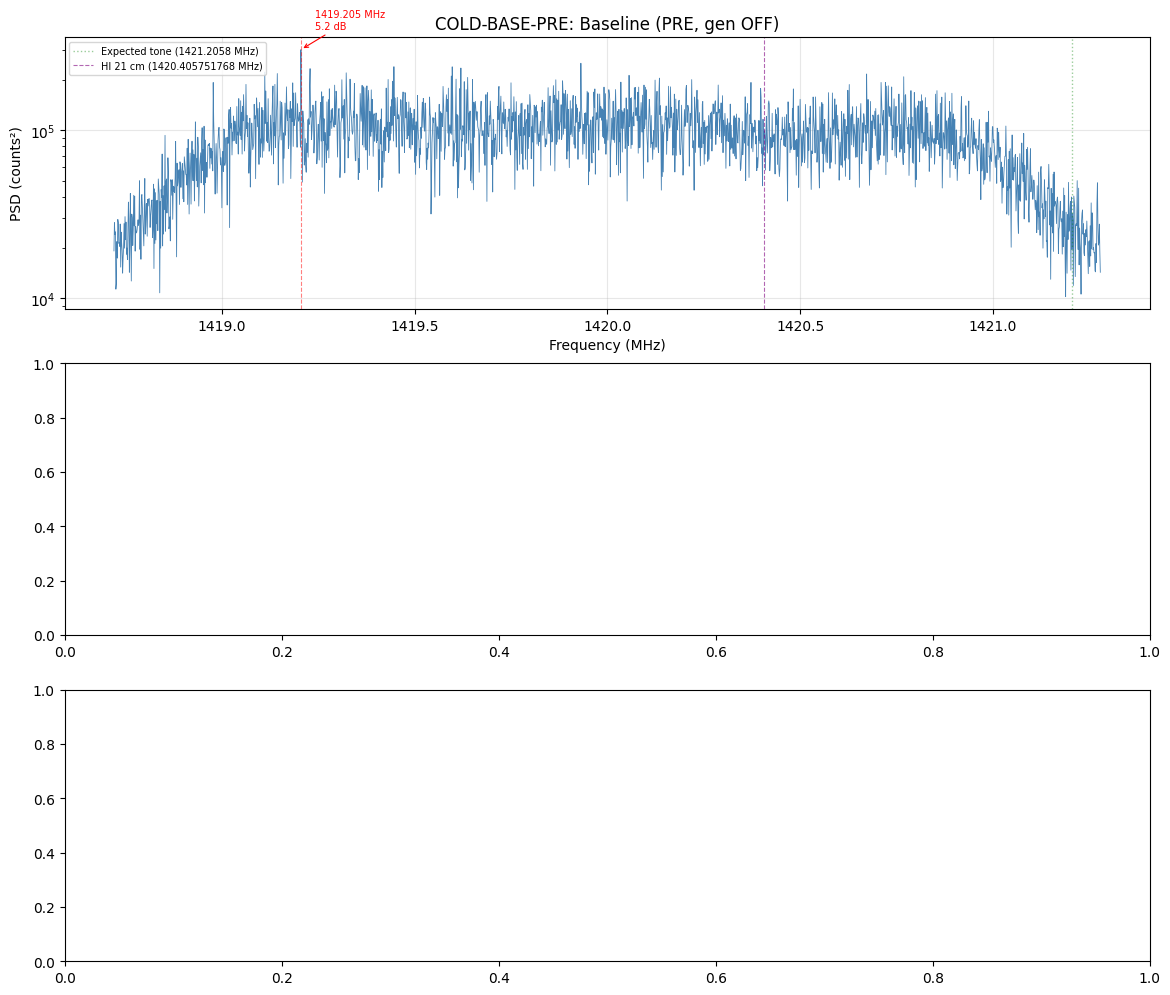

In [8]:
# Annotated peak identification on a few representative spectra
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

examples = [
    ('COLD-BASE-PRE', 'Baseline (PRE, gen OFF)'),
    ('COLD-TONE--40', 'Tone at -40 dBm (mid-range)'),
    ('COLD-TONE--30', 'Tone at -30 dBm (strongest)'),
]

tone_freq_mhz = 1421.2058

for ax, (key, title) in zip(axes, examples):
    row = df.loc[df['prefix'] == key].iloc[0]
    freqs = row['freqs_mhz']
    psd = row['psd']

    ax.semilogy(freqs, psd, lw=0.6, color='steelblue')

    # Mark detected peaks
    peaks = find_significant_peaks(freqs, psd, prominence_factor=3.0)
    for p in peaks:
        ax.axvline(p['freq_mhz'], color='red', alpha=0.5, lw=0.8, ls='--')
        ax.annotate(
            f"{p['freq_mhz']:.3f} MHz\n{p['snr_over_median_dB']:.1f} dB",
            xy=(p['freq_mhz'], p['psd']),
            xytext=(10, 15), textcoords='offset points',
            fontsize=7, color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=0.8),
        )

    # Mark expected tone location
    ax.axvline(tone_freq_mhz, color='green', alpha=0.4, lw=1, ls=':',
               label=f'Expected tone ({tone_freq_mhz} MHz)')
    # Mark HI 21-cm line
    ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--',
               label=f'HI 21 cm ({HI_FREQ} MHz)')

    ax.set_ylabel('PSD (counts²)')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_title(f'{key}: {title}')
    ax.legend(loc='upper left', fontsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('Peak Identification in Power Spectra', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# --- Step 3: Baseline subtraction ---
# For each dBm level, subtract the paired baseline PSD from the tone PSD
# to isolate the injected signal from system noise.

tone_freq_mhz = 1421.2058

sub_rows = []
for dbm in paired_dbm:
    tone_row = df.loc[df['prefix'] == f'COLD-TONE-{dbm}'].iloc[0]
    base_row = df.loc[df['prefix'] == f'COLD-BASE-{dbm}'].iloc[0]

    freqs = tone_row['freqs_mhz']
    diff_psd = tone_row['psd'] - base_row['psd']

    tone_bin = np.argmin(np.abs(freqs - tone_freq_mhz))

    sub_rows.append({
        'siggen_amp_dBm': dbm,
        'freqs_mhz': freqs,
        'diff_psd': diff_psd,
        'tone_bin_diff': diff_psd[tone_bin],
        'tone_bin_psd_cal': tone_row['psd'][tone_bin],
        'tone_bin_psd_base': base_row['psd'][tone_bin],
        'total_diff': np.sum(diff_psd),
        'mean_diff': np.mean(diff_psd),
    })

sub_df = pd.DataFrame(sub_rows)

# Summary table
print('Baseline-subtracted tone power at 1421.205 MHz:')
print(sub_df[['siggen_amp_dBm', 'tone_bin_psd_cal', 'tone_bin_psd_base',
              'tone_bin_diff', 'total_diff', 'mean_diff']].to_string(index=False))



In [ ]:
# Baseline-subtracted spectra (cal - obs) for each available dBm level
fig, axes = plt.subplots(len(sub_df), 1, figsize=(12, 4 * len(sub_df)))
axes = np.atleast_1d(axes)

for i, row in sub_df.iterrows():
    ax = axes[i]
    dbm = row['siggen_amp_dBm']
    freqs = row['freqs_mhz']
    diff = row['diff_psd']

    ax.plot(freqs, diff, lw=0.6, color='darkgreen')
    ax.axhline(0, color='gray', lw=0.5, ls='-')
    ax.axvline(tone_freq_mhz, color='green', alpha=0.4, lw=1, ls=':',
               label=f'Tone ({tone_freq_mhz} MHz)')
    ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--',
               label=f'HI 21 cm ({HI_FREQ} MHz)')
    ax.set_ylabel('ΔPSD (counts²)')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_title(f'{int(dbm)} dBm: cal − baseline')
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('Baseline-Subtracted Power Spectra (tone ON − tone OFF)', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()



In [ ]:
# Baseline-subtracted statistics DataFrame
sub_stats = sub_df[['siggen_amp_dBm', 'tone_bin_diff', 'total_diff', 'mean_diff']].copy()
sub_stats['tone_diff_dB'] = 10 * np.log10(np.abs(sub_stats['tone_bin_diff']))
sub_stats['tone_diff_positive'] = sub_stats['tone_bin_diff'] > 0
sub_stats

In [ ]:
# --- Step 4: Linearity check ---
# Plot measured tone power vs input power (dBm).
# On a dB-vs-dB scale, a linear receiver should give slope ≈ 1.

from scipy.stats import linregress

# Use baseline-subtracted tone power at the tone bin
input_dbm = sub_df['siggen_amp_dBm'].values.astype(float)
tone_power = sub_df['tone_bin_diff'].values.astype(float)

# Also use total integrated power difference (more robust)
total_diff = sub_df['total_diff'].values.astype(float)

# Only fit where tone_bin_diff > 0 (tone is detectable above noise)
mask = tone_power > 0
input_fit = input_dbm[mask]
tone_power_fit = tone_power[mask]
tone_power_db = 10 * np.log10(tone_power_fit)

# Linear regression on dB vs dBm
slope, intercept, r_value, p_value, std_err = linregress(input_fit, tone_power_db)

print(f'Linearity fit (baseline-subtracted tone bin):')
print(f'  Points used: {mask.sum()} / {len(mask)} (where cal > base)')
print(f'  Slope:     {slope:.4f} dB/dBm  (ideal = 1.0)')
print(f'  Intercept: {intercept:.2f} dB')
print(f'  R²:        {r_value**2:.6f}')
print(f'  Std error: {std_err:.4f}')
print()

# Also fit total integrated power
mask_total = total_diff > 0
input_fit_t = input_dbm[mask_total]
total_db = 10 * np.log10(total_diff[mask_total])
slope_t, intercept_t, r_t, _, stderr_t = linregress(input_fit_t, total_db)

print(f'Linearity fit (total integrated power diff):')
print(f'  Points used: {mask_total.sum()} / {len(mask_total)}')
print(f'  Slope:     {slope_t:.4f} dB/dBm  (ideal = 1.0)')
print(f'  Intercept: {intercept_t:.2f} dB')
print(f'  R²:        {r_t**2:.6f}')

In [ ]:
# Linearity plot: measured output power (dB) vs input power (dBm)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Left: tone bin power ---
# Plot all points, color by whether they were included in the fit
ax1.scatter(input_dbm[~mask], 10 * np.log10(np.abs(tone_power[~mask])),
            marker='x', color='gray', s=30, label='Excluded (cal ≤ base)', zorder=3)
ax1.scatter(input_fit, tone_power_db,
            marker='o', color='steelblue', s=30, label='Fit points', zorder=3)

# Fit line
x_line = np.linspace(input_fit.min(), input_fit.max(), 100)
ax1.plot(x_line, slope * x_line + intercept, 'r-', lw=1.5,
         label=f'Fit: slope={slope:.3f}, R²={r_value**2:.4f}')

# Ideal slope=1 reference
ax1.plot(x_line, 1.0 * x_line + intercept, 'k--', lw=0.8, alpha=0.5,
         label='Ideal slope=1')

ax1.set_xlabel('Input power (dBm)')
ax1.set_ylabel('Measured tone bin power (dB)')
ax1.set_title('Linearity: tone bin (baseline-subtracted)')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# --- Right: total integrated power ---
ax2.scatter(input_dbm[~mask_total], 10 * np.log10(np.abs(total_diff[~mask_total])),
            marker='x', color='gray', s=30, label='Excluded (total ≤ 0)', zorder=3)
ax2.scatter(input_fit_t, total_db,
            marker='o', color='darkorange', s=30, label='Fit points', zorder=3)

x_line_t = np.linspace(input_fit_t.min(), input_fit_t.max(), 100)
ax2.plot(x_line_t, slope_t * x_line_t + intercept_t, 'r-', lw=1.5,
         label=f'Fit: slope={slope_t:.3f}, R²={r_t**2:.4f}')
ax2.plot(x_line_t, 1.0 * x_line_t + intercept_t, 'k--', lw=0.8, alpha=0.5,
         label='Ideal slope=1')

ax2.set_xlabel('Input power (dBm)')
ax2.set_ylabel('Measured total ΔPSD (dB)')
ax2.set_title('Linearity: total integrated power (baseline-subtracted)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

fig.suptitle('Receiver Linearity Check', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Residuals from ideal linearity
fig, ax = plt.subplots(figsize=(10, 5))

residual = tone_power_db - (slope * input_fit + intercept)
ideal_residual = tone_power_db - (1.0 * input_fit + intercept)

ax.stem(input_fit, residual, linefmt='steelblue', markerfmt='o', basefmt='gray',
        label=f'Residual from fit (slope={slope:.3f})')
ax.stem(input_fit, ideal_residual, linefmt='orange', markerfmt='s', basefmt='gray',
        label='Residual from ideal (slope=1)')
ax.axhline(0, color='gray', lw=0.5)
ax.set_xlabel('Input power (dBm)')
ax.set_ylabel('Residual (dB)')
ax.set_title('Linearity Residuals at Tone Bin')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# --- Step 5: Noise floor & system temperature ---
# Characterize the system noise from baseline-only captures.
# T_sys = P_noise / (k_B * B) where B = bandwidth per bin

k_B = 1.380649e-23  # Boltzmann constant (J/K)
sample_rate_hz = df['sample_rate'].iloc[0]
nsamples = 2048
bin_bw = sample_rate_hz / nsamples  # Hz per bin

# Collect noise statistics from all 23 baseline (obs) captures
obs_df = df[df['type'] == 'obs'].copy()

noise_rows = []
for _, row in obs_df.iterrows():
    psd = row['psd']
    iq = row['samples']

    # Exclude DC bin (center) and tone bin region for clean noise estimate
    freqs = row['freqs_mhz']
    dc_bin = np.argmin(np.abs(freqs - 1420.0))
    tone_bin = np.argmin(np.abs(freqs - tone_freq_mhz))

    # Mask: exclude ±5 bins around DC and tone
    mask = np.ones(len(psd), dtype=bool)
    mask[max(0, dc_bin-5):dc_bin+6] = False
    mask[max(0, tone_bin-5):tone_bin+6] = False

    clean_psd = psd[mask]

    # RMS voltage from time domain
    vrms = np.sqrt(np.mean(np.abs(iq)**2))

    noise_rows.append({
        'prefix': row['prefix'],
        'unix_time': row['unix_time'],
        'mean_psd': np.mean(clean_psd),
        'median_psd': np.median(clean_psd),
        'std_psd': np.std(clean_psd),
        'total_power': np.sum(psd),
        'vrms': vrms,
    })

noise_df = pd.DataFrame(noise_rows)

print('Baseline noise statistics (obs captures, excluding DC & tone bins):')
print(f'  Mean PSD across baselines:   {noise_df["mean_psd"].mean():.1f} counts²')
print(f'  Std of mean PSD:             {noise_df["mean_psd"].std():.1f} counts²')
print(f'  Mean Vrms:                   {noise_df["vrms"].mean():.2f} counts')
print(f'  Bin bandwidth:               {bin_bw:.1f} Hz')
print(f'  Total bandwidth:             {sample_rate_hz/1e6:.2f} MHz')
print()
noise_df

In [ ]:
# System temperature estimate using the calibration slope
# From step 4, we have: measured_dB = slope * input_dBm + intercept
# The noise floor in the same units lets us estimate T_sys.
#
# Method: use the linearity fit from total integrated power (more robust).
# At the noise floor (no tone), the total power is just system noise.
# P_noise (counts²) = mean baseline total_power
# P_tone (counts²) at known input → calibration factor counts²/Watt
# T_sys = P_noise / (cal_factor * k_B * B)

# Use a high-SNR cal point for calibration (e.g. -30 dBm)
cal_dbm = -30.0
cal_row = sub_df.loc[sub_df['siggen_amp_dBm'] == cal_dbm].iloc[0]
cal_power_watts = 10**((cal_dbm) / 10) * 1e-3  # dBm to Watts

# Baseline-subtracted total power at this level = counts² from the tone alone
cal_counts2 = cal_row['total_diff']

# Calibration factor: counts² per Watt
cal_factor = cal_counts2 / cal_power_watts

# Mean noise floor from baselines (total power)
mean_noise_counts2 = noise_df['total_power'].mean()

# Noise power in Watts
noise_watts = mean_noise_counts2 / cal_factor

# System temperature: P = k_B * T * B
T_sys = noise_watts / (k_B * sample_rate_hz)

print(f'Calibration reference: {cal_dbm} dBm = {cal_power_watts:.2e} W')
print(f'  Baseline-subtracted counts²: {cal_counts2:.3e}')
print(f'  Calibration factor: {cal_factor:.3e} counts²/W')
print()
print(f'Mean baseline noise:')
print(f'  Total PSD: {mean_noise_counts2:.3e} counts²')
print(f'  Equivalent power: {noise_watts:.3e} W')
print()
print(f'System temperature estimate:')
print(f'  T_sys = {T_sys:.0f} K')
print()
print('Note: This is a rough estimate. The ADC quantization, gain chain,')
print('and impedance matching all affect the absolute calibration.')

In [ ]:
# Noise floor visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: overlay all baseline spectra
ax = axes[0, 0]
for _, row in obs_df.iterrows():
    ax.semilogy(row['freqs_mhz'], row['psd'], lw=0.3, alpha=0.5)
ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--', label='HI 21 cm')
ax.axvline(1420.0, color='red', alpha=0.4, lw=0.8, ls=':', label='DC (1420 MHz)')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts²)')
ax.set_title(f'All {len(obs_df)} baseline spectra overlaid')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Top-right: mean ± std baseline spectrum
ax = axes[0, 1]
all_psd = np.array([row['psd'] for _, row in obs_df.iterrows()])
mean_psd = np.mean(all_psd, axis=0)
std_psd = np.std(all_psd, axis=0)
freqs = obs_df.iloc[0]['freqs_mhz']
ax.semilogy(freqs, mean_psd, lw=0.8, color='steelblue', label='Mean')
ax.fill_between(freqs, mean_psd - std_psd, mean_psd + std_psd,
                alpha=0.3, color='steelblue', label='±1σ')
ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts²)')
ax.set_title('Mean baseline spectrum ± 1σ')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Bottom-left: noise Vrms over time
ax = axes[1, 0]
t_min = (noise_df['unix_time'] - noise_df['unix_time'].iloc[0]) / 60
ax.plot(t_min, noise_df['vrms'], 'o-', ms=4, color='steelblue')
ax.set_xlabel('Time since start (min)')
ax.set_ylabel('Vrms (counts)')
ax.set_title('Baseline Vrms over time')
ax.grid(True, alpha=0.3)

# Bottom-right: total power over time
ax = axes[1, 1]
ax.plot(t_min, noise_df['total_power'], 's-', ms=4, color='darkorange')
ax.set_xlabel('Time since start (min)')
ax.set_ylabel('Total PSD (counts²)')
ax.set_title('Baseline total power over time')
ax.grid(True, alpha=0.3)

fig.suptitle('Noise Floor Characterization (baseline captures only)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# --- Step 6: Drift check ---
# Quantify how the baseline total power drifts over the observation window.

# Elapsed time for baseline captures
t0 = noise_df['unix_time'].iloc[0]
noise_df['elapsed_min'] = (noise_df['unix_time'] - t0) / 60.0

# Elapsed time for cal captures (join via prefix → df unix_time)
cal_df = df[df['type'] == 'cal'].copy()
cal_df['elapsed_min'] = (cal_df['unix_time'] - t0) / 60.0
# Merge cal timestamps into psd_stats
psd_stats['elapsed_min'] = cal_df['elapsed_min'].values

# Linear fit to baseline total power vs time
slope_drift, intercept_drift, r_drift, _, stderr_drift = linregress(
    noise_df['elapsed_min'], noise_df['total_power']
)

window_min = noise_df['elapsed_min'].iloc[-1] - noise_df['elapsed_min'].iloc[0]
total_drift = slope_drift * window_min
pct_drift = 100 * total_drift / noise_df['total_power'].mean()

print('Baseline drift analysis:')
print(f'  Observation window:  {window_min:.1f} min')
print(f'  Drift rate:          {slope_drift:.2e} counts²/min')
print(f'  Total drift:         {total_drift:.2e} counts² ({pct_drift:.2f}% of mean)')
print(f'  R²:                  {r_drift**2:.4f}')
print(f'  Std error of slope:  {stderr_drift:.2e} counts²/min')

In [ ]:
# Step 6 — Drift visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: baseline total power vs elapsed time + linear fit
ax1.plot(noise_df['elapsed_min'], noise_df['total_power'], 'o-', ms=5,
         color='steelblue', label='Baseline total power')
x_fit = np.linspace(noise_df['elapsed_min'].min(), noise_df['elapsed_min'].max(), 100)
ax1.plot(x_fit, slope_drift * x_fit + intercept_drift, 'r--', lw=1.5,
         label=f'Fit: {slope_drift:.2e} counts²/min ({pct_drift:+.2f}% over window)')
ax1.set_ylabel('Total PSD (counts²)')
ax1.set_title('Baseline Drift Over Observation Window')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Bottom: cal total power vs elapsed time, colored by dBm
sc = ax2.scatter(psd_stats['elapsed_min'], psd_stats['tone_total_psd'],
                 c=psd_stats['siggen_amp_dBm'], cmap='viridis', s=40, zorder=3)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Signal gen (dBm)')
ax2.set_ylabel('Cal total PSD (counts²)')
ax2.set_xlabel('Elapsed time (min)')
ax2.set_title('Calibration Capture Total Power Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# --- Step 7: Build calibration curve ---
# Convert dBm → Watts, fit linear region, derive system temperature.

# Input power in Watts
sub_df['P_watts'] = 10**(sub_df['siggen_amp_dBm'] / 10) * 1e-3

# Identify linear region: total_diff must be well above the noise floor
noise_floor_std = noise_df['total_power'].std()
linear_mask = sub_df['total_diff'] > 3 * noise_floor_std

print(f'Noise floor std:       {noise_floor_std:.2e} counts²')
print(f'3σ threshold:          {3 * noise_floor_std:.2e} counts²')
print(f'Linear region points:  {linear_mask.sum()} / {len(sub_df)}')
print(f'Usable dBm range:      {sub_df.loc[linear_mask, "siggen_amp_dBm"].min():.0f} '
      f'to {sub_df.loc[linear_mask, "siggen_amp_dBm"].max():.0f} dBm')
print()

# Linear regression: Watts → counts² (total_diff)
P_lin = sub_df.loc[linear_mask, 'P_watts'].values
counts2_lin = sub_df.loc[linear_mask, 'total_diff'].values

slope_cal, intercept_cal, r_cal, _, stderr_cal = linregress(P_lin, counts2_lin)

print(f'Calibration fit (linear region):')
print(f'  Slope:               {slope_cal:.4e} counts²/W')
print(f'  Intercept:           {intercept_cal:.2e} counts²')
print(f'  R²:                  {r_cal**2:.6f}')
print(f'  Conversion factor:   {1/slope_cal:.4e} W/count²')
print()

# System temperature from calibration slope
mean_noise = noise_df['total_power'].mean()
T_sys_cal = mean_noise / (slope_cal * k_B * sample_rate_hz)

print(f'System temperature (from calibration curve):')
print(f'  Mean baseline power: {mean_noise:.3e} counts²')
print(f'  T_sys = {T_sys_cal:.0f} K')
print(f'  (Step 5 estimate:    {T_sys:.0f} K)')

In [ ]:
# Step 7 — Calibration curve visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# --- Top: linear scale (Watts vs counts²) ---
# All points
ax1.scatter(sub_df['P_watts'], sub_df['total_diff'], c='gray', s=30,
            label='All points', zorder=2)
# Linear region highlighted
ax1.scatter(sub_df.loc[linear_mask, 'P_watts'],
            sub_df.loc[linear_mask, 'total_diff'],
            c='steelblue', s=50, label='Linear region', zorder=3)

# Fit line over extended range
P_range = np.linspace(0, sub_df['P_watts'].max() * 1.1, 200)
ax1.plot(P_range, slope_cal * P_range + intercept_cal, 'r-', lw=1.5,
         label=f'Fit: slope={slope_cal:.2e} counts²/W, R²={r_cal**2:.4f}')

# Noise floor
ax1.axhline(3 * noise_floor_std, color='orange', ls='--', lw=1,
            label=f'3σ noise floor = {3*noise_floor_std:.2e}')
ax1.axhline(0, color='gray', lw=0.5)

ax1.set_xlabel('Input power (W)')
ax1.set_ylabel('Baseline-subtracted total PSD (counts²)')
ax1.set_title('Calibration Curve — Linear Scale')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# --- Bottom: log-log (dBm vs dB) showing full dynamic range ---
# Convert total_diff to dB (use abs for log, mark sign)
total_diff_all = sub_df['total_diff'].values
positive = total_diff_all > 0

# Plot positive values in dB
input_dbm_all = sub_df['siggen_amp_dBm'].values
ax2.scatter(input_dbm_all[positive],
            10 * np.log10(total_diff_all[positive]),
            c='steelblue', s=40, label='Positive ΔP', zorder=3)
ax2.scatter(input_dbm_all[~positive],
            10 * np.log10(np.abs(total_diff_all[~positive])),
            c='red', marker='x', s=40, label='Negative ΔP (|value|)', zorder=3)

# Extrapolated fit line across full dBm range
dbm_range = np.linspace(-55, -25, 200)
P_range_w = 10**(dbm_range / 10) * 1e-3
fit_counts2 = slope_cal * P_range_w + intercept_cal
fit_positive = fit_counts2 > 0
ax2.plot(dbm_range[fit_positive],
         10 * np.log10(fit_counts2[fit_positive]),
         'r--', lw=1.5, label='Extrapolated fit')

# Mark linear region bounds
dbm_min = sub_df.loc[linear_mask, 'siggen_amp_dBm'].min()
dbm_max = sub_df.loc[linear_mask, 'siggen_amp_dBm'].max()
ax2.axvspan(dbm_min, dbm_max, alpha=0.1, color='steelblue', label='Linear region')

# Noise floor in dB
ax2.axhline(10 * np.log10(3 * noise_floor_std), color='orange', ls='--', lw=1,
            label='3σ noise floor')

ax2.set_xlabel('Input power (dBm)')
ax2.set_ylabel('Baseline-subtracted total PSD (dB)')
ax2.set_title('Calibration Curve — Log Scale (Full Dynamic Range)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()